In [1]:
import numpy as np
from scipy import stats
import pickle
import pandas as pd
import matplotlib.patches as mpatches
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def real_match(a,b):
    return a > b

In [3]:
#with probabilty p the weaker player wins
def stoch_match(a,b, p=0.15):
    if np.random.random() >= p:
        return a > b
    else:
        return a < b

In [108]:
def maj_stoch_match(a,b, p=0.15, num=5):
    decs = []
    for _ in range(num):
        if np.random.random() >= p:
            decs.append(a>b)
        else:
            decs.append(a<b)

    return sorted(decs)[int(num/2)]

In [57]:
def exspected_score(rating_1, rating_2):
    e_1 = 1 / (1 + 10**((rating_2-rating_1)/400))
    return e_1

In [58]:
def update_score(rating, s, e, k=16):
    rating_p = rating + k*(s-e)
    return rating_p

In [59]:
class Player:
    def __init__(self, strength):
        self.strength = strength
        self.rating = 1200
        self.num_matches = 0

    def set_rating(self, rating):
        self.rating = rating
    
    def get_strength(self):
        return self.strength
    
    def get_rating(self):
        return self.rating

    def increment_num_matches(self):
        self.num_matches +=1
    
    def get_num_matches(self):
        return self.num_matches

In [60]:
def start_tournament(players, size=1000, match_p = 0.15, maj_vote=False):
    num_players = len(players)

    for t in range(size):
        player_selection = np.random.permutation(range(num_players))[:2]
        p1, p2 = players[player_selection[0]], players[player_selection[1]]

        if maj_vote:
            p1_won = maj_stoch_match(p1.get_strength(), p2.get_strength(), p=match_p) 
        else:
            p1_won = stoch_match(p1.get_strength(), p2.get_strength(), p=match_p)

        p1.increment_num_matches()
        p2.increment_num_matches()

        e1 = exspected_score(p1.get_rating(), p2.get_rating())
        e2 = 1-e1

        if p1_won:
            p1_new_rating = update_score(p1.get_rating(), 1, e1)
            p2_new_rating = update_score(p2.get_rating(), 0, e2)

            p1.set_rating(p1_new_rating)
            p2.set_rating(p2_new_rating)

        else:
            p1_new_rating = update_score(p1.get_rating(), 0, e1)
            p2_new_rating = update_score(p2.get_rating(), 1, e2)

            p1.set_rating(p1_new_rating)
            p2.set_rating(p2_new_rating)

    a = [p.get_strength() for p in players]
    b = [p.get_rating() for p in players]

    res = stats.spearmanr(a, b)
    return res.statistic


In [61]:
def start_simulation(num_players=94, tourn_size_multi=1, runs=10, distr="normal", effort="15", match_p=0.15, maj_vote=False):

    #number of annotations
    tourn_size = int(tourn_size_multi*num_players)
    
    #assumes perfect decision every match. should be at least 0.7 (very strong correlation)
    fair_scores = []

    for run in range(runs):
        if distr == "normal":
            players = [Player(np.round(s, 100)) for s in np.random.normal(0.5, 0.1, num_players)]
        if distr == "uniform":
            players = [Player(np.round(s, 100)) for s in np.linspace(0.0, 1, num_players)]
        
        fairness = start_tournament(players=players, size=tourn_size, match_p=match_p, maj_vote=maj_vote)
        fair_scores.append(fairness)

    avg_fairness = np.round(np.mean(fair_scores), 4)
    std_fairness = np.round(np.std(fair_scores), 4)
    effort = tourn_size*effort/60
    return {"Rank correlation": avg_fairness, "STD fairness": std_fairness, "Annotation time in mins.": effort}


In [76]:
#number of different texts
num_players = 94

#number of simulations (just to robustify the fairness score)
runs = 20

#distribition of simplicity scores (does not effect robustness as it is rank correlation)
distr = "normal"

#effort per match in seconds
effort = 15

tourn_size_multis=[0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]  
results = {}

for tourn_size_multi in tourn_size_multis:
    res = start_simulation(num_players, tourn_size_multi, runs, distr, effort, match_p=0.0)
    res2 = start_simulation(num_players, tourn_size_multi, runs, distr, effort, match_p=0.15)
    res3 = start_simulation(num_players, tourn_size_multi, runs, distr, effort, match_p=0.15, maj_vote=True)
    res['Rank correlation subjective'] = res2['Rank correlation']
    res['Rank correlation subjective majority'] =  res3['Rank correlation']
    print(f"{tourn_size_multi} : {res}")
    results[tourn_size_multi] = res

0.5 : {'Rank correlation': 0.5303, 'STD fairness': 0.0394, 'Annotation time in mins.': 11.75, 'Rank correlation subjective': 0.3884, 'Rank correlation subjective majority': 0.4993}
1 : {'Rank correlation': 0.6668, 'STD fairness': 0.0314, 'Annotation time in mins.': 23.5, 'Rank correlation subjective': 0.4718, 'Rank correlation subjective majority': 0.6351}
2 : {'Rank correlation': 0.801, 'STD fairness': 0.0215, 'Annotation time in mins.': 47.0, 'Rank correlation subjective': 0.638, 'Rank correlation subjective majority': 0.7761}
3 : {'Rank correlation': 0.8485, 'STD fairness': 0.0171, 'Annotation time in mins.': 70.5, 'Rank correlation subjective': 0.7285, 'Rank correlation subjective majority': 0.8174}
4 : {'Rank correlation': 0.8849, 'STD fairness': 0.0186, 'Annotation time in mins.': 94.0, 'Rank correlation subjective': 0.7736, 'Rank correlation subjective majority': 0.8703}
5 : {'Rank correlation': 0.8976, 'STD fairness': 0.0174, 'Annotation time in mins.': 117.5, 'Rank correlation

In [77]:
sim_stats = pd.DataFrame.from_dict(results).T

In [78]:
sim_stats['Number of Pairs'] = sim_stats.index*num_players

In [79]:
sim_stats

,Rank correlation,STD fairness,Annotation time in mins.,Rank correlation subjective,Rank correlation subjective majority,Number of Pairs
0.5,0.5303,0.0394,11.75,0.3884,0.4993,47.0
1.0,0.6668,0.0314,23.50,0.4718,0.6351,94.0
2.0,0.8010,0.0215,47.00,0.6380,0.7761,188.0
3.0,0.8485,0.0171,70.50,0.7285,0.8174,282.0
4.0,0.8849,0.0186,94.00,0.7736,0.8703,376.0
5.0,0.8976,0.0174,117.50,0.8046,0.8898,470.0
6.0,0.9098,0.0113,141.00,0.8295,0.9105,564.0
7.0,0.9297,0.0082,164.50,0.8585,0.9195,658.0
8.0,0.9392,0.0061,188.00,0.8705,0.9257,752.0
9.0,0.9429,0.0065,211.50,0.8789,0.9351,846.0


In [80]:
sns.set_style('darkgrid')

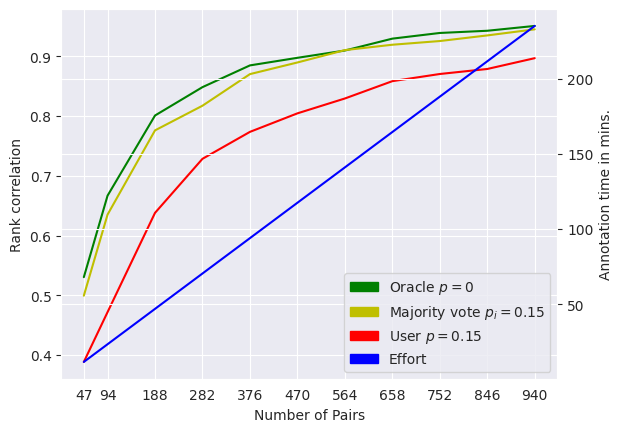

In [82]:
g = sns.lineplot(data=sim_stats, x="Number of Pairs", y="Rank correlation", color="g", label="g", legend=False)
g1 = sns.lineplot(data=sim_stats, x="Number of Pairs", y="Rank correlation subjective", color="r", label="r",  legend=False)
g1_2 = sns.lineplot(data=sim_stats, x="Number of Pairs", y="Rank correlation subjective majority", color="y", label="y",  legend=False)
g2 = sns.lineplot(data=sim_stats, x="Number of Pairs",y="Annotation time in mins.", color="b", ax=g.axes.twinx(), label="b", legend=False)
#g2.set_xticks(list(range(len(sim_stats['Number of Pairs']))))
g2.set_xticks(sim_stats['Number of Pairs'].tolist())


green_patch = mpatches.Patch(color='g', label= r'Oracle $p=0$')
red_patch = mpatches.Patch(color='r', label= r'User $p=0.15$')
yellow_patch = mpatches.Patch(color='y', label= r'Majority vote $p_{i}=0.15$')
blue_patch = mpatches.Patch(color='b', label='Effort')


plt.legend(handles=[green_patch,yellow_patch, red_patch, blue_patch], loc='lower right')
plt.savefig("workspace/numpairs_rankcorr_effort.pdf")

In [87]:
#generate determined pairs for matchmaking

num_indices = len(arts_94)
num_goal_pairs = num_indices*4
match_pairs = []
indx_list = []


while len(match_pairs) < num_goal_pairs:
    if len(indx_list) < 2:
        indx_list = list(np.random.permutation(num_indices))
    
    new_pair = (indx_list.pop(), indx_list.pop())
    match_pairs.append(new_pair)

In [89]:
pickle.dump(match_pairs, open(f"workspace/data/determined_pairs_{num_goal_pairs}.pkl", "wb"))